### About
- This notebook is an implementation of the following papers.
    - [Depth Map Prediction from a Single Image using a Multi-Scale Deep Network](https://arxiv.org/pdf/1406.2283.pdf) by Eigen et al., NIPS 2014
- Dataset
    - [NYU Depth Dataset V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)

In [69]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils
from skimage import transform
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import time
import os
import re
import random
from imageio import imread
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Device configuration

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyper parameters

In [71]:
num_epochs = 20 # not specified in paper

### Dataset loader

In [72]:
data_dir_train = Path('../../../data/nyu/valid_')
data_dir_valid = Path('../../../data/nyu/valid_')

class DepthEigenDataset(Dataset):

    def __init__(self, rgb_dir, depth_dir, transform=None):
        super(DepthEigenDataset, self).__init__()
        
        self.rgb_dir = rgb_dir
        self.depth_dir = depth_dir
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.rgb_dir))
    
    def __getitem__(self, idx):
         
        # read as PIL images
        rgb_sample = Image.open(self.rgb_dir / '{}.ppm'.format(idx))
        depth_sample = Image.open(self.depth_dir / '{}.pgm'.format(idx))
        
        # transform
        seed = random.randint(0, 2 ** 32)
        if self.transform:
            random.seed(seed)
            rgb_sample = self.transform(rgb_sample)
            
            random.seed(seed)
            depth_sample = self.transform(depth_sample)
        
        # resize depth image
        depth_sample = transforms.Resize((74, 55))(depth_sample)
        
        # convert to torch tensor
        rgb_sample = transforms.ToTensor()(rgb_sample)
        depth_sample = transforms.ToTensor()(depth_sample).view(74, 55)
        
        sample = {'rgb':rgb_sample, 'depth': depth_sample}
        
        return sample

trans_train = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop((304, 228)),
    transforms.RandomHorizontalFlip(),
])

trans_test = transforms.Compose([
    transforms.Resize((304, 228)),
])
    
dataset_train = DepthEigenDataset(data_dir_train / 'rgb', data_dir_train / 'depth', transform=trans_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_valid = DepthEigenDataset(data_dir_valid / 'rgb', data_dir_valid / 'depth', transform=trans_test)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True)

datalen_train = len(dataset_train)
datalen_valid = len(dataset_valid)

print(datalen_train, datalen_valid)

100 100


### Network definition

In [73]:
class GlobalCoarseNet(nn.Module):
    
    def __init__(self):
        super(GlobalCoarseNet, self).__init__()
        
        self.coarse1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        self.coarse2 = nn.Sequential(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        
        self.coarse3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), 
                                     nn.ReLU())
        
        self.coarse4 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), 
                                     nn.ReLU())
        
        self.coarse5 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=2), 
                                     nn.ReLU())
        
        self.coarse6 = nn.Sequential(nn.Linear(in_features=256 * 8 * 6, out_features=4096), 
                                     nn.ReLU(), nn.Dropout(0.5))
        
        self.coarse7 = nn.Linear(in_features=4096, out_features=74 * 55)
        
    
    def forward(self, x):
        x = self.coarse1(x)
        x = self.coarse2(x)
        x = self.coarse3(x)
        x = self.coarse4(x)
        x = self.coarse5(x)
        x = x.reshape(x.size(0), -1)
        x = self.coarse6(x)
        x = self.coarse7(x)
        x = x.reshape(x.size(0), 74, 55)
        return x

class LocalFineNet(nn.Module):
    
    def __init__(self):
        super(LocalFineNet, self).__init__()
        
        self.fine1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=63, kernel_size=9, stride=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        
        self.fine2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2), 
                                   nn.ReLU())
        
        self.fine3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
    
    def forward(self, x, global_output_batch):
        x = self.fine1(x)
        x = torch.cat((x, global_output_batch), dim=1)
        x = self.fine2(x)
        x = self.fine3(x)
        
        return x

# initialize
global_model = GlobalCoarseNet().to(device)
local_model = LocalFineNet().to(device)

### Loss and optimizer
- Reference
    - [Per-parameter options](https://pytorch.org/docs/stable/optim.html)

In [74]:
class ScaleInvariantLoss(nn.Module):
    def __init__(self):
        super(ScaleInvariantLoss, self).__init__()

    def forward(self, pred, target):
        
        # mask out 0 values for log function
        mask = (target == 0)
        dist = pred[~mask] - torch.log(target[~mask])
        
        # the lambda parameter is set to 0.5
        loss = torch.mean(dist ** 2) - 0.5 / ((torch.numel(dist)) ** 2) * (torch.sum(dist) ** 2) 
        
        return loss

# loss
global_criterion = ScaleInvariantLoss()
local_criterion = ScaleInvariantLoss()

# optimizer
r=1
global_optimizer = torch.optim.SGD([{'params': global_model.coarse6.parameters(), 'lr': 0.1*r},
                                    {'params': global_model.coarse7.parameters(), 'lr': 0.1*r}], 
                                   lr=0.001*r, momentum=0.9)

local_optimizer = torch.optim.SGD([{'params': local_model.fine2.parameters(), 'lr': 0.01*r}], 
                                  lr=0.001*r, momentum=0.9)

# data parallel
global_model = nn.DataParallel(global_model)
local_model = nn.DataParallel(local_model)

### Plot gradient flow and losses
- Reference
    - [plot function](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/7)
    - [get gradient of each layer](https://discuss.pytorch.org/t/how-to-calculate-gradient-for-each-layer/1595/4)

In [75]:
def plot_grad_flow(layers, avg_grads):        
    
    for avg_grad in avg_grads:
        plt.plot(avg_grad, alpha=0.3, color="b")
        
    plt.hlines(0, 0, len(layers)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(layers), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(layers))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

def plot_losses(train_losses, valid_losses):
    plt.plot(train_losses, label='train losses')
    plt.plot(valid_losses, label='valid losses')
    
    plt.xlabel("Iterations")
    plt.ylabel("Losses")
    
    plt.legend()
    plt.title("Losses")
    plt.grid(True)

### Train the global coarse model

> > > > > > > > > > > > > > > > > > > > Time used:  45.19631886482239  per epoch used:  2.2598159432411196


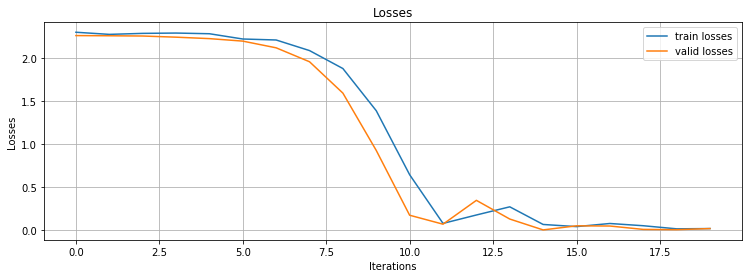

In [76]:
figsize(12.5, 4)

train_losses = []
valid_losses = []

avg_grads = []
start = time.time()
for epoch in range(num_epochs):
    
    print('>', end=' ')
    
    # train
    train_loss = 0
    global_model.train()
    for i, samples in enumerate(dataloader_train):
        
        rgbs = samples['rgb'].float().to(device)
        depths = samples['depth'].float().to(device)
        
        # forward pass
        output = global_model(rgbs)
        loss = global_criterion(output, depths)

        # backward pass
        global_model.zero_grad()
        loss.backward()

        # optimization
        global_optimizer.step()
        
        train_loss += loss.item()
        
    train_losses.append(train_loss / datalen_train)
    
    # validation
    valid_loss = 0
    global_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):
        
            rgbs = samples['rgb'].float().to(device)
            depths = samples['depth'].float().to(device)

            # forward pass
            output = global_model(rgbs)
            loss = global_criterion(output, depths)
            
            valid_loss += loss.item()
            
    valid_losses.append(valid_loss / datalen_valid)
    
elapse = time.time() - start 
print('Time used: ', elapse, ' per epoch used: ', elapse / num_epochs)

plot_losses(train_losses, valid_losses)

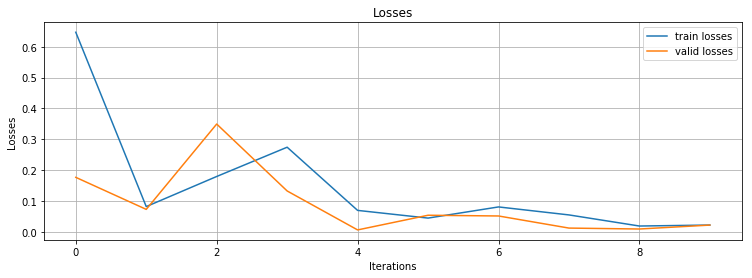

In [77]:
plot_losses(train_losses[10:], valid_losses[10:])

### Train the local fine model

> > > > > > > > > > > > > > > > > > > > Time used:  43.49681377410889  per epoch used:  2.1748406887054443


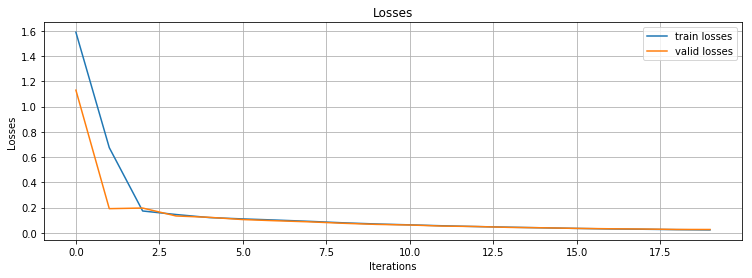

In [78]:
figsize(12.5, 4)

train_losses, valid_losses = [], []
avg_grads = []
start = time.time()
for epoch in range(num_epochs):
    
    print('>', end=' ')
    
    # train
    train_loss = 0
    local_model.train()
    for i, samples in enumerate(dataloader_train):
        
        rgbs = samples['rgb'].float().to(device)
        depths = samples['depth'].float().to(device)
        
        # results from global coarse network
        global_model.eval()
        with torch.no_grad():
            global_output = global_model(rgbs).unsqueeze(1)

        # forward pass
        output = local_model(rgbs, global_output).squeeze(1)
        loss = local_criterion(output, depths)

        # backward pass
        local_model.zero_grad()
        loss.backward()

        # avarage gradient
        avg_grad = []
        for n, p in local_model.named_parameters():
            if 'bias' in n:
                continue
            avg_grad.append(p.grad.abs().mean())
        avg_grads.append(avg_grad)

        # optimization
        local_optimizer.step()
        
        train_loss += loss.item()
        
    train_losses.append(train_loss / datalen_train)

    # valid
    valid_loss = 0
    local_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):

            rgbs = samples['rgb'].float().to(device)
            depths = samples['depth'].float().to(device)

            # results from global coarse network
            global_model.eval()
            with torch.no_grad():
                global_output = global_model(rgbs).unsqueeze(1)

            # forward pass
            output = local_model(rgbs, global_output).squeeze(1)
            loss = local_criterion(output, depths)
            
            valid_loss += loss.item()
    valid_losses.append(valid_loss / datalen_valid)

elapse = time.time() - start 
print('Time used: ', elapse, ' per epoch used: ', elapse / num_epochs)

plot_losses(train_losses, valid_losses)

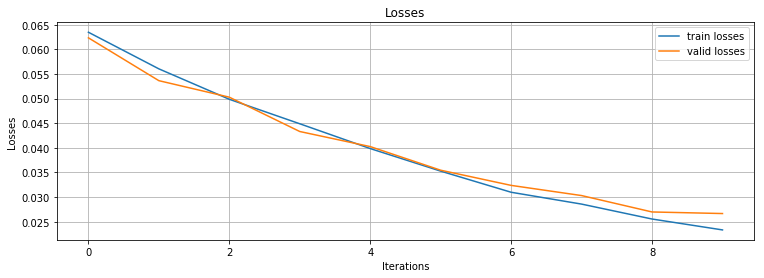

In [79]:
plot_losses(train_losses[10:], valid_losses[10:])

### Validation

In [80]:
for i, samples in enumerate(dataloader_valid):

    rgbs = samples['rgb'].float().to(device)
    depths = samples['depth'].float().to(device)

    # results from global coarse network
    global_model.eval()
    with torch.no_grad():
        global_output = global_model(rgbs).unsqueeze(1)
    
    # results from local fine network
    local_model.eval()
    with torch.no_grad():
        local_output = local_model(rgbs, global_output)
    
    break

torch.Size([74, 55])


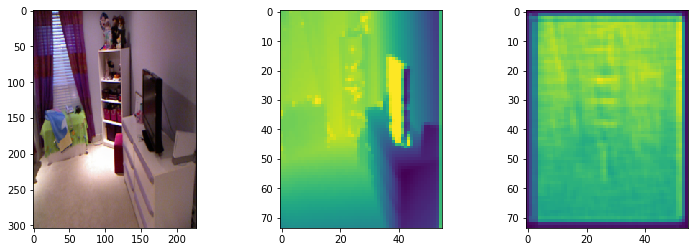

torch.Size([74, 55])


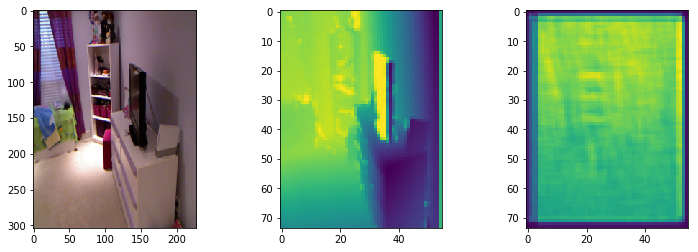

torch.Size([74, 55])


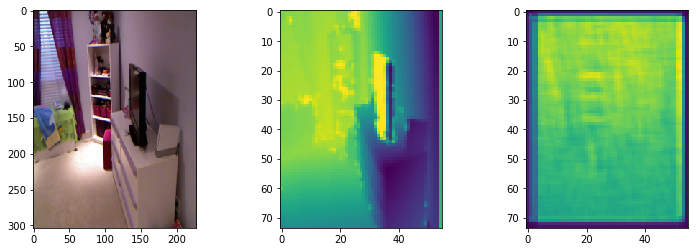

torch.Size([74, 55])


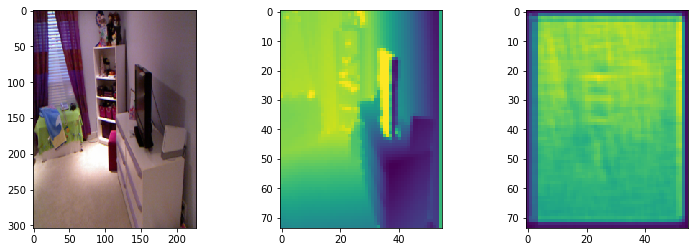

torch.Size([74, 55])


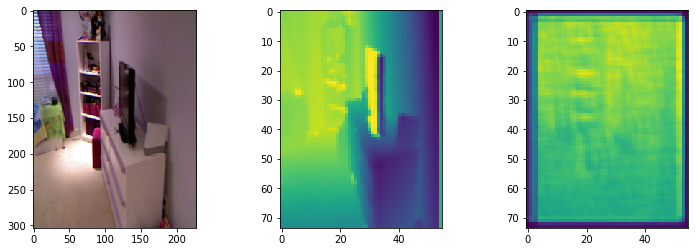

torch.Size([74, 55])


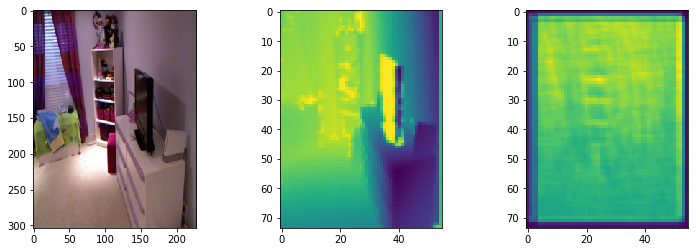

torch.Size([74, 55])


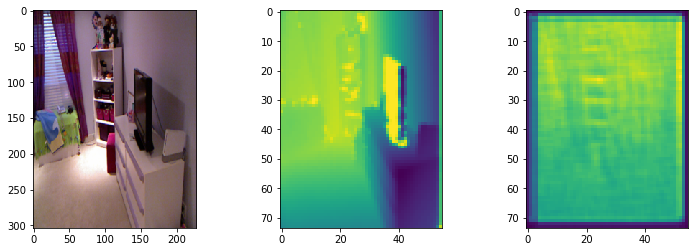

torch.Size([74, 55])


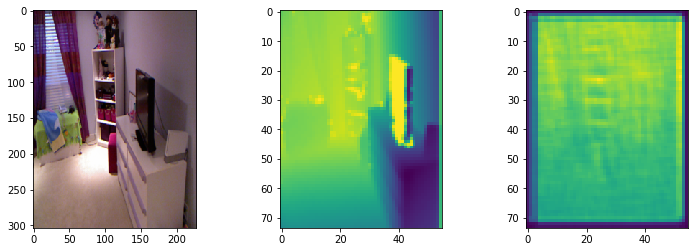

torch.Size([74, 55])


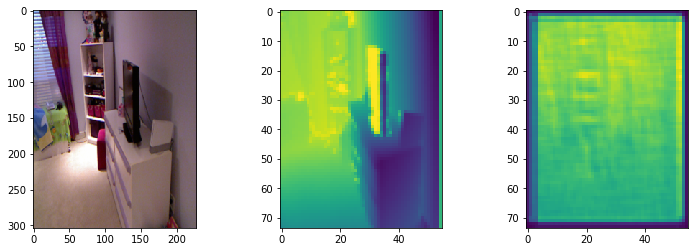

torch.Size([74, 55])


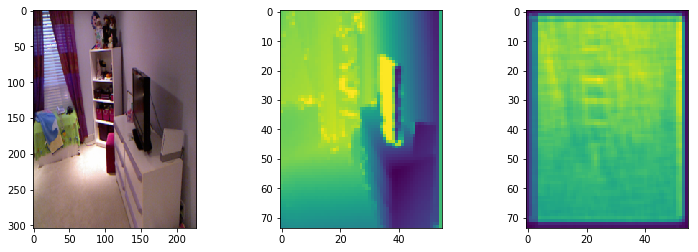

torch.Size([74, 55])


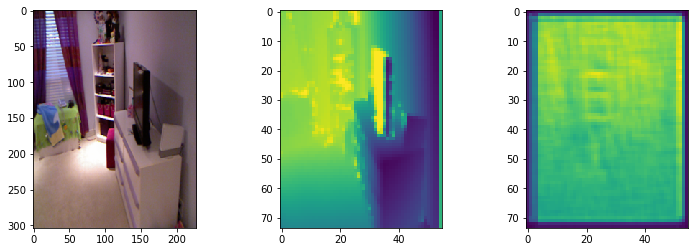

torch.Size([74, 55])


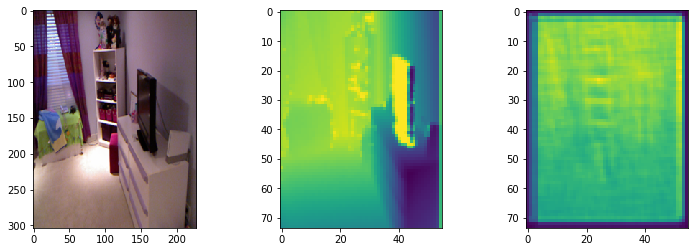

torch.Size([74, 55])


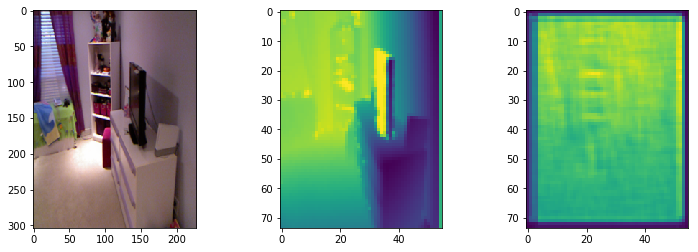

torch.Size([74, 55])


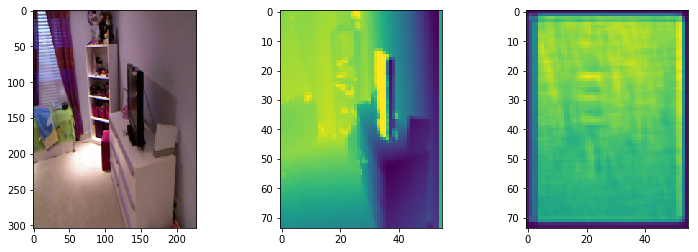

torch.Size([74, 55])


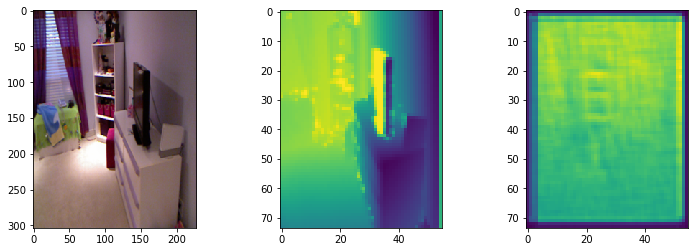

torch.Size([74, 55])


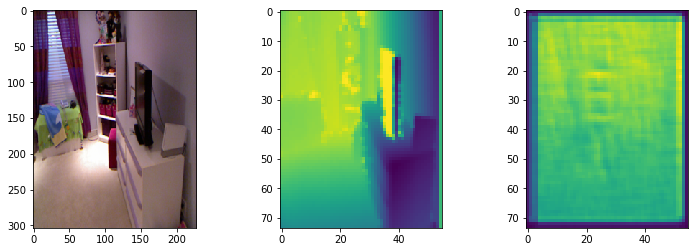

torch.Size([74, 55])


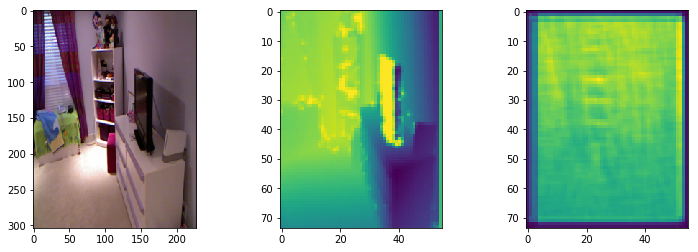

torch.Size([74, 55])


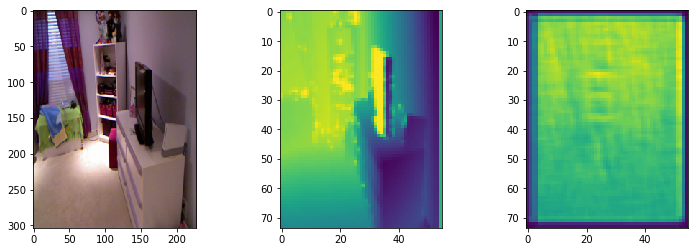

torch.Size([74, 55])


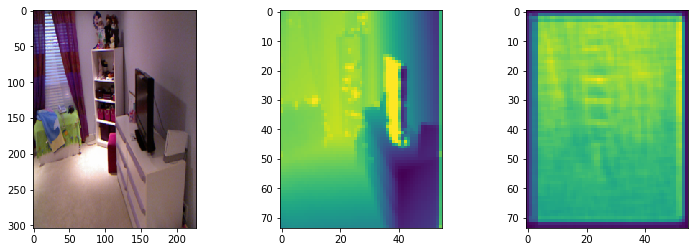

torch.Size([74, 55])


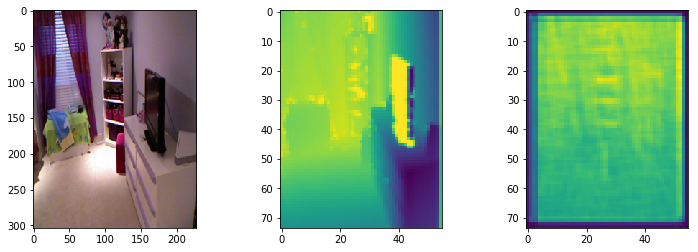

torch.Size([74, 55])


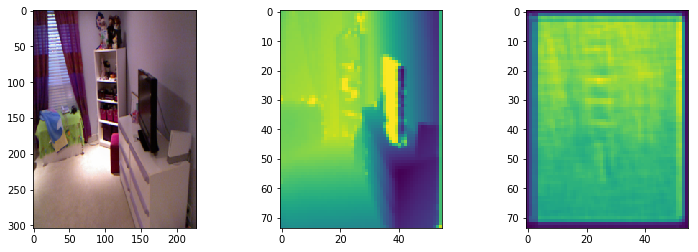

torch.Size([74, 55])


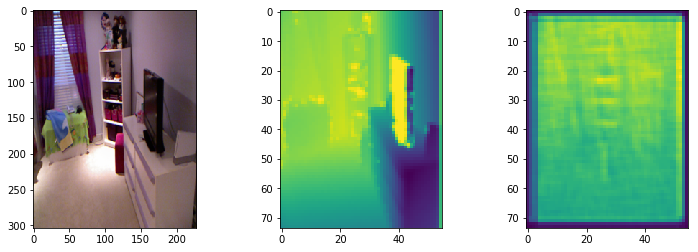

torch.Size([74, 55])


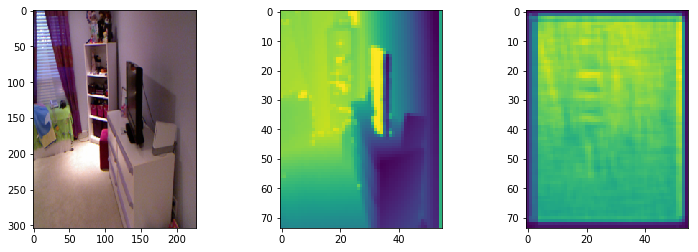

torch.Size([74, 55])


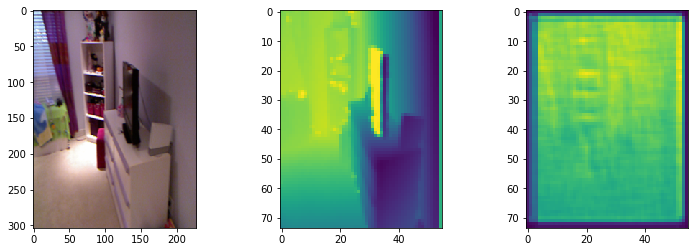

torch.Size([74, 55])


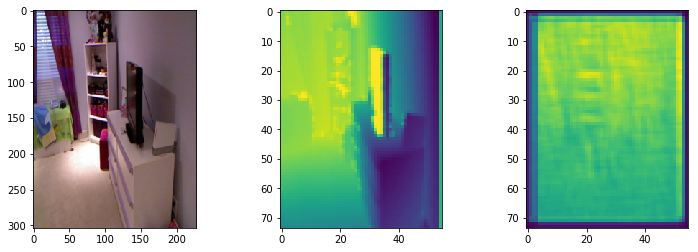

torch.Size([74, 55])


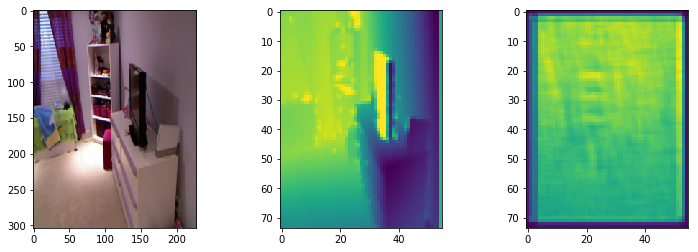

torch.Size([74, 55])


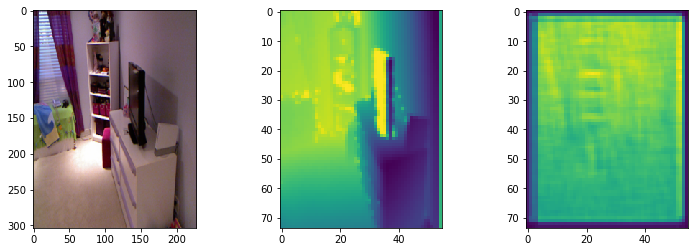

torch.Size([74, 55])


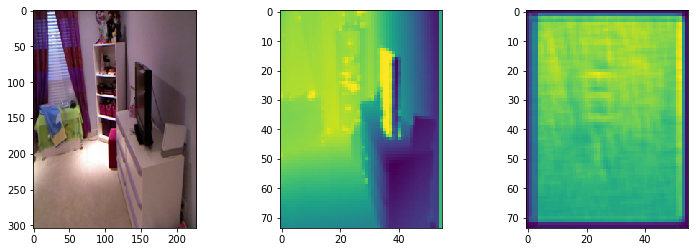

torch.Size([74, 55])


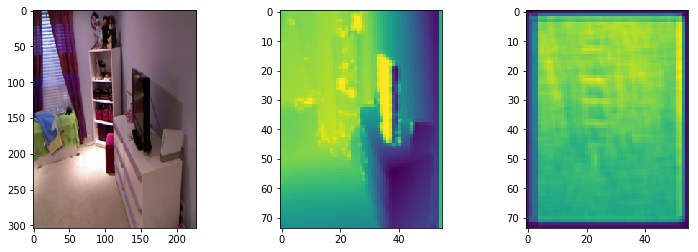

torch.Size([74, 55])


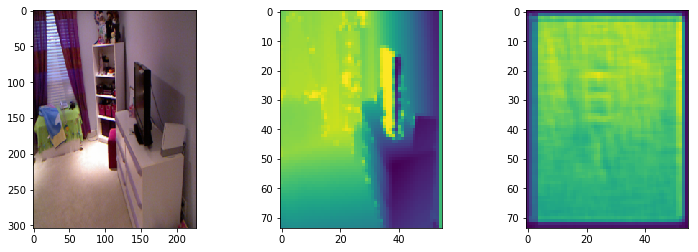

torch.Size([74, 55])


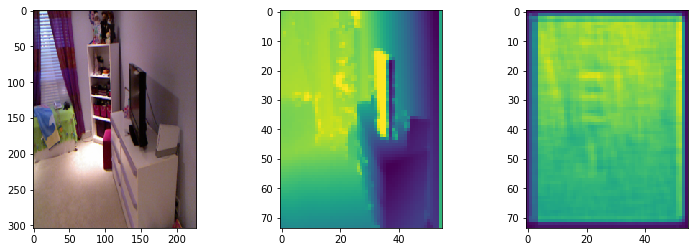

torch.Size([74, 55])


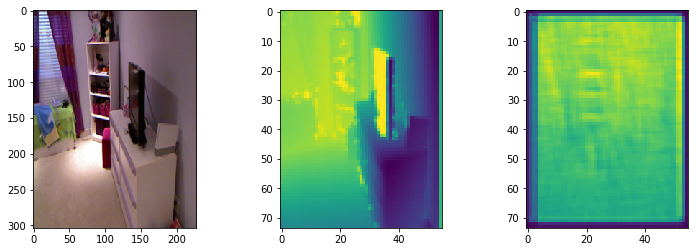

In [81]:
for i in range(32):

    d = local_output[i].view(74, 55)
    d = torch.exp(d)
    r = transforms.ToPILImage()(rgbs[i].cpu())
    d_true = depths[i]
    
    
    plt.subplot(131)
    plt.imshow(r)
    
    plt.subplot(132)
    print(d_true.shape)
    plt.imshow(d_true.cpu())
    
    plt.subplot(133)
    plt.imshow(d.cpu())

    plt.show()